# Проект по анализу ЗП.

## Описание данных:

Для анализа предоставлены данные о видах, стоимости каждой услуги одного из сотрудников Graph Design компании.


**Виды услуг:**
 - Создание сайта,
 - Логотип, 
 - Инстаграм,
 - Фейсбук, 
 - Вконтакте,
 - Чат-бот,
 - Баннер,
 - Визитка

**Стоимость проектов:**
 - Создание сайта - 1600 руб.
 - Логотип - 13831 руб.
 - Инстаграм - 7990 руб.
 - Фейсбук - 5320 руб.
 - Вконтакте - 7990 руб.
 - Чат-бот - 7820 руб.
 - Баннер - 2000 руб.
 - Визитка - 2000 руб.


**Названия столбцов:**


 - created - Клиент сделал заказ.
 - start_date - Проект взят в работу.
 - end_date	- Проект отдан клиенту.
 - projects - Название проекта.	

**Цель** проекта - проанализировать динамику заработной платы сотрудника, выявить определенные закономерности и тенденции, проиллюстрировать результаты с помощью инструментов визуализации.

## Обработка данных

In [1]:
import pandas as pd
import locale

import datetime  
from datetime import datetime

from dateutil.relativedelta import relativedelta
from datetime import date

from plotly import graph_objects as go
import matplotlib.pyplot as plt

import plotly.express as px
import warnings
warnings.filterwarnings("ignore")

from IPython.display import display, HTML
from scipy import stats as st

import numpy as np
import statsmodels.api as sm

from statsmodels.formula.api import ols
import plotly.io as pio

In [2]:
data = pd.read_csv('design_data.csv')

In [3]:
def first_look (df):
  '''Функция получения первичной информации о датафрейме'''
  print ('------------- Первые 5 строк ------------')
  display(df.head())
  print('')
  print('')
  print ('------------- Типы данных ------------')
  print (df.info())
  print('')
  print('')
  print ('------------- Пропуски ------------')
  count = 0
  for element in df.columns:
    if df[element].isna().sum() > 0: 
      print(element, ' - ', df[element].isna().sum(), 'пропусков')
      count = +1
  if count == 0:
    print('Пропусков НЕТ')
  print('')
  print('')
  print ('------------- Дубликаты ------------')
  if df.duplicated().sum() > 0:
    print('Дубликатов: ', df.duplicated().sum())
  else:
    print('Дубликатов НЕТ')

In [4]:
first_look(data)

------------- Первые 5 строк ------------


,created,start_date,end_date,projects
0,04 июля 2023 в 14:52,05 июл 2023,07 июл 2023,логотип
1,06 июля 2023 в 16:21,06 июл 2023,07 июл 2023,чат-бот
2,06 июля 2023 в 00:41,06 июл 2023,07 июл 2023,логотип
3,06 июля 2023 в 12:51,06 июл 2023,07 июл 2023,визитка
4,07 июля 2023 в 03:01,07 июл 2023,07 июл 2023,facebook




------------- Типы данных ------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175 entries, 0 to 174
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   created     175 non-null    object
 1   start_date  175 non-null    object
 2   end_date    175 non-null    object
 3   projects    175 non-null    object
dtypes: object(4)
memory usage: 5.6+ KB
None


------------- Пропуски ------------
Пропусков НЕТ


------------- Дубликаты ------------
Дубликатов:  1


По первой оценке данных видно, что столбцы с датами не приведены к нужному типу, так же как и названия столбцов.

In [5]:
data.columns = data.columns.str.lower()

In [6]:
data.head()

,created,start_date,end_date,projects
0,04 июля 2023 в 14:52,05 июл 2023,07 июл 2023,логотип
1,06 июля 2023 в 16:21,06 июл 2023,07 июл 2023,чат-бот
2,06 июля 2023 в 00:41,06 июл 2023,07 июл 2023,логотип
3,06 июля 2023 в 12:51,06 июл 2023,07 июл 2023,визитка
4,07 июля 2023 в 03:01,07 июл 2023,07 июл 2023,facebook


In [7]:
#Уберем предлог "в" и время, чтобы привести всю дату к единому формату.
data['created'] = data['created'].str.split(' в').str[0]

In [8]:
locale.setlocale(
    category=locale.LC_ALL,
    locale="Russian"
)

data['start_date'] = pd.to_datetime(data['start_date'], format = '%d %b %Y')
data['end_date'] = pd.to_datetime(data['end_date'], format = '%d %b %Y')
data['created'] = pd.to_datetime(data['end_date'], format = '%d %b %Y')

In [9]:
data['created'].min()

Timestamp('2023-06-16 00:00:00')

In [10]:
data['end_date'].max()

Timestamp('2023-07-07 00:00:00')

In [11]:
days = data['end_date'].max()-data['created'].min()
days = int(str(days).split(' ')[0])
days

21

In [12]:
week = 7

In [13]:
weeks = days/week
weeks

3.0

In [14]:
print(f'Данные для анализа находятся в промежутке с {data.created.min().strftime("%Y-%m-%d")} по {data.end_date.max().strftime("%Y-%m-%d")}, то есть {days} день.')

Данные для анализа находятся в промежутке с 2023-06-16 по 2023-07-07, то есть 21 день.


In [15]:
project = data.projects.value_counts()
project

создание_сайта    51
логотип           44
facebook          41
чат-бот           30
inst               4
VK                 3
визитка            1
баннер             1
Name: projects, dtype: int64

In [16]:
print(f'Больше всего было выполнено проектов по проектам {project.index[0]}, а также {project.index[1]} и {project.index[2]}. Неприоритетными в этом отчетном периоде оказались: {project.index[-1]}, {project.index[-2]} и {project.index[-3]}.')

Больше всего было выполнено проектов по проектам создание_сайта, а также логотип и facebook. Неприоритетными в этом отчетном периоде оказались: баннер, визитка и VK.


Обратим внимание на стоимость проектов :

 - Логотип - 13831 руб.
 - Инстаграм - 7990 руб.
 - Вконтакте - 7990 руб.
 - Чат-бот - 7820 руб.
 - Фейсбук - 5320 руб.
 - Баннер - 2000 руб.
 - Визитка - 2000 руб.
 - Создание сайта - 1600 руб.

Для максимизации прибыли необходимо выполнять проекты из первой 3-ки или 5-ки из списка стоимотей проектов. В 3-ке наиболее часто выполняемых проектов: сам проект - самый прибыльный, а также декомпозиция и Выпускной проект, которые соответствуют минимальной и средней стоимости соответственно. 

С точки зрения максимизации прибыли - ситуация может быть улучшена засчет решения проектов с большей стоимостью, однако на текущей вакансии присутствуют другие обязательные параметры выбора проектов, на которые сотрудник не может повлиять.

## Расчеты

Напишем функцию для подсчета ЗП за текущий период.

In [17]:
prices = {
    'создание_сайта': 1600,
    'логотип': 13830,
    'inst': 7990,
    'facebook': 5320,
    'VK': 7990,
    'чат-бот': 7820,
    'баннер': 2000,
    'визитка': 2000
}

In [18]:
data['income'] = data['projects'].map(prices)

In [19]:
salary = data['income'].sum()

In [20]:
print(f' Зарпалата за текущий период без учета налога = {salary}, ЗП с учетом налога = {round(salary * 0.94,2)} ')

 Зарпалата за текущий период без учета налога = 1202770, ЗП с учетом налога = 1130603.8 


In [21]:
sal_week = round(salary/weeks)
print(f'Средняя зарплата за неделю составляет {sal_week} рублей')

Средняя зарплата за неделю составляет 400923 рублей


In [22]:
sal_day = salary/days
print(f'Средняя зарплата за день составляет {round(sal_day,2)} рублей')

Средняя зарплата за день составляет 57274.76 рублей


In [23]:
print(f'ЗП за {days} день составила - {salary} руб. без учета налога. С учетом налога: {round(salary * 0.94,2)}. В среднем получается, что недельный заработок составил {sal_week} руб, а дневной - {sal_day} руб.')

ЗП за 21 день составила - 1202770 руб. без учета налога. С учетом налога: 1130603.8. В среднем получается, что недельный заработок составил 400923 руб, а дневной - 57274.76190476191 руб.


In [24]:
all_pr = len(data.projects)
print(f' Всего за {days} день было сделано {all_pr} проектов')

 Всего за 21 день было сделано 175 проектов


In [25]:
pr_week = all_pr/3
print(f' В среднем за неделю выполняется {round(pr_week,2)} проектов')

 В среднем за неделю выполняется 58.33 проектов


In [26]:
pr_day = all_pr/21
print(f' В среднем за день выполняется {round(pr_day,2)} проектов')

 В среднем за день выполняется 8.33 проектов


In [27]:
print(f' В среднем в день 1 проект приносит {round(sal_day/pr_day, 2)} рублей')

 В среднем в день 1 проект приносит 6872.97 рублей


In [28]:
accepted_pr = data.groupby('start_date')['projects'].count().sort_values(ascending = False)
accepted_pr

start_date
2023-06-26    18
2023-07-05    16
2023-07-02    16
2023-07-03    13
2023-06-27    12
2023-06-22    11
2023-06-30     9
2023-06-28     8
2023-07-06     8
2023-06-19     8
2023-06-24     8
2023-06-16     7
2023-06-23     7
2023-06-25     6
2023-06-29     5
2023-07-01     5
2023-07-04     4
2023-06-20     4
2023-06-18     4
2023-06-17     3
2023-06-21     2
2023-07-07     1
Name: projects, dtype: int64

In [29]:
print(f'Больше всего проектов было принято {accepted_pr.index.strftime("%Y-%m-%d")[0]}, а также {accepted_pr.index.strftime("%Y-%m-%d")[1]} и {accepted_pr.index.strftime("%Y-%m-%d")[2]} от {accepted_pr.values[0]} до {accepted_pr.values[2]} соответсвенно. Наименее активными оказались {accepted_pr.index.strftime("%Y-%m-%d")[-1]} и {accepted_pr.index.strftime("%Y-%m-%d")[-2]}, менее {accepted_pr.values[-2]} проектов  ')

Больше всего проектов было принято 2023-06-26, а также 2023-07-05 и 2023-07-02 от 18 до 16 соответсвенно. Наименее активными оказались 2023-07-07 и 2023-06-21, менее 2 проектов  


In [30]:
completed_pr = data.groupby('end_date')['projects'].count().sort_values(ascending = False)
completed_pr

end_date
2023-07-05    20
2023-06-22    15
2023-07-02    14
2023-06-26    14
2023-06-27    13
2023-06-30    12
2023-06-24    11
2023-07-06     9
2023-07-03     9
2023-06-25     8
2023-07-04     7
2023-06-28     7
2023-06-29     6
2023-07-07     6
2023-06-18     6
2023-06-17     5
2023-06-19     4
2023-06-21     3
2023-06-23     2
2023-06-16     2
2023-07-01     1
2023-06-20     1
Name: projects, dtype: int64

In [31]:
print(f'Завершено проектов больше всего было {completed_pr.index.strftime("%Y-%m-%d")[0]} - {completed_pr.values[0]} проектов, а также {completed_pr.index.strftime("%Y-%m-%d")[-1]}. Меньше всего проектов завершилось {completed_pr.index.strftime("%Y-%m-%d")[-1]},{completed_pr.index.strftime("%Y-%m-%d")[-2]} и {completed_pr.index.strftime("%Y-%m-%d")[-3]}.')

Завершено проектов больше всего было 2023-07-05 - 20 проектов, а также 2023-06-20. Меньше всего проектов завершилось 2023-06-20,2023-07-01 и 2023-06-16.


In [32]:
clients = data.groupby('created')['projects'].count().sort_values(ascending = False)
clients

created
2023-07-05    20
2023-06-22    15
2023-07-02    14
2023-06-26    14
2023-06-27    13
2023-06-30    12
2023-06-24    11
2023-07-06     9
2023-07-03     9
2023-06-25     8
2023-07-04     7
2023-06-28     7
2023-06-29     6
2023-07-07     6
2023-06-18     6
2023-06-17     5
2023-06-19     4
2023-06-21     3
2023-06-23     2
2023-06-16     2
2023-07-01     1
2023-06-20     1
Name: projects, dtype: int64

In [33]:
print(f'Клиенты тоже были активными {clients.index.strftime("%Y-%m-%d")[0]} и прислали целых {clients.values[0]} проектов за день, {clients.index.strftime("%Y-%m-%d")[1]} тоже был пик, но уже поменьше - {clients.values[1]} проектов. Меньше всего клиенты заказывали проекты в {clients.index.strftime("%Y-%m-%d")[-1]},{clients.index.strftime("%Y-%m-%d")[-2]} и {clients.index.strftime("%Y-%m-%d")[-3]}  числах.')

Клиенты тоже были активными 2023-07-05 и прислали целых 20 проектов за день, 2023-06-22 тоже был пик, но уже поменьше - 15 проектов. Меньше всего клиенты заказывали проекты в 2023-06-20,2023-07-01 и 2023-06-16  числах.


In [34]:
print(f'Проанализировав активность отдельно по датам, можно сделать вывод, что дизайнер берет проект ,чаще всего, в тот же день, в какой его присылает заказчик. Определенный пик можно наблюдать {clients.index.strftime("%Y-%m-%d")[0]} и {clients.index.strftime("%Y-%m-%d")[1]}. Интересно, связано ли эта активность с днем недели.')

Проанализировав активность отдельно по датам, можно сделать вывод, что дизайнер берет проект ,чаще всего, в тот же день, в какой его присылает заказчик. Определенный пик можно наблюдать 2023-07-05 и 2023-06-22. Интересно, связано ли эта активность с днем недели.


In [35]:
data['week_day_started'] = data['start_date'].dt.day_name()
data['week_day_created'] = data['created'].dt.day_name()
data['week_day_ended'] = data['end_date'].dt.day_name()

Добавив колонку с днем недели для даты, когда клиент прислал проект, и для даты, когда дизайнер принял проект, теперь можно определить, в какой день недели наибольшая активность.

In [36]:
data.head()

,created,start_date,end_date,projects,income,week_day_started,week_day_created,week_day_ended
0,2023-07-07,2023-07-05,2023-07-07,логотип,13830,Wednesday,Friday,Friday
1,2023-07-07,2023-07-06,2023-07-07,чат-бот,7820,Thursday,Friday,Friday
2,2023-07-07,2023-07-06,2023-07-07,логотип,13830,Thursday,Friday,Friday
3,2023-07-07,2023-07-06,2023-07-07,визитка,2000,Thursday,Friday,Friday
4,2023-07-07,2023-07-07,2023-07-07,facebook,5320,Friday,Friday,Friday


In [37]:
peak_days = data[data.start_date.isin([clients.index[0], clients.index[1]])]
peak_days.head()

,created,start_date,end_date,projects,income,week_day_started,week_day_created,week_day_ended
0,2023-07-07,2023-07-05,2023-07-07,логотип,13830,Wednesday,Friday,Friday
9,2023-07-06,2023-07-05,2023-07-06,чат-бот,7820,Wednesday,Thursday,Thursday
14,2023-07-06,2023-07-05,2023-07-06,чат-бот,7820,Wednesday,Thursday,Thursday
25,2023-07-05,2023-07-05,2023-07-05,facebook,5320,Wednesday,Wednesday,Wednesday
26,2023-07-05,2023-07-05,2023-07-05,создание_сайта,1600,Wednesday,Wednesday,Wednesday


In [38]:
print(f'Мы видим, что пиковые дни по кол-ву проектов приходятся на {clients.index.strftime("%Y-%m-%d")[0]}, то есть {peak_days.iat[0,4]}, и {clients.index.strftime("%Y-%m-%d")[1]} - {peak_days.iat[-1,4]}.')

Мы видим, что пиковые дни по кол-ву проектов приходятся на 2023-07-05, то есть 13830, и 2023-06-22 - 5320.


In [39]:
count_of_pr_per_wd = data.groupby('week_day_started')['projects'].count().sort_values(ascending = False)
count_of_pr_per_wd

week_day_started
Monday       39
Sunday       26
Wednesday    26
Friday       24
Thursday     24
Tuesday      20
Saturday     16
Name: projects, dtype: int64

In [40]:
print(f'{count_of_pr_per_wd.index[0]} - тяжелый день, на него приходится наибольшее кол-во работы. А меньше всего проектов ревьюер проверяет в {count_of_pr_per_wd.index[-1]} и в {count_of_pr_per_wd.index[-2]}.')

Monday - тяжелый день, на него приходится наибольшее кол-во работы. А меньше всего проектов ревьюер проверяет в Saturday и в Tuesday.


In [41]:
dyn_by_clients = data.groupby('week_day_created')['projects'].count().sort_values(ascending = False)
dyn_by_clients

week_day_created
Thursday     30
Wednesday    30
Sunday       28
Monday       27
Friday       22
Tuesday      21
Saturday     17
Name: projects, dtype: int64

In [42]:
print(f'А вот клиенты имеют другую динамику по заказу проектов. Явными лидерами стали - {dyn_by_clients.index[0], dyn_by_clients.index[1]}. Меньше всего проектов присылают в {dyn_by_clients.index[-1]}.')

А вот клиенты имеют другую динамику по заказу проектов. Явными лидерами стали - ('Thursday', 'Wednesday'). Меньше всего проектов присылают в Saturday.


## Визуализация

**Дашборд по динамике количества выполненных проектов в разрезе дней**

In [43]:
dynamics = data.groupby('week_day_ended')['projects'].count().sort_values(ascending = False )
dynamics

week_day_ended
Thursday     30
Wednesday    30
Sunday       28
Monday       27
Friday       22
Tuesday      21
Saturday     17
Name: projects, dtype: int64

In [44]:
pio.renderers.default = "svg"
svg_renderer = pio.renderers["svg"]
svg_renderer.scale = 1.2

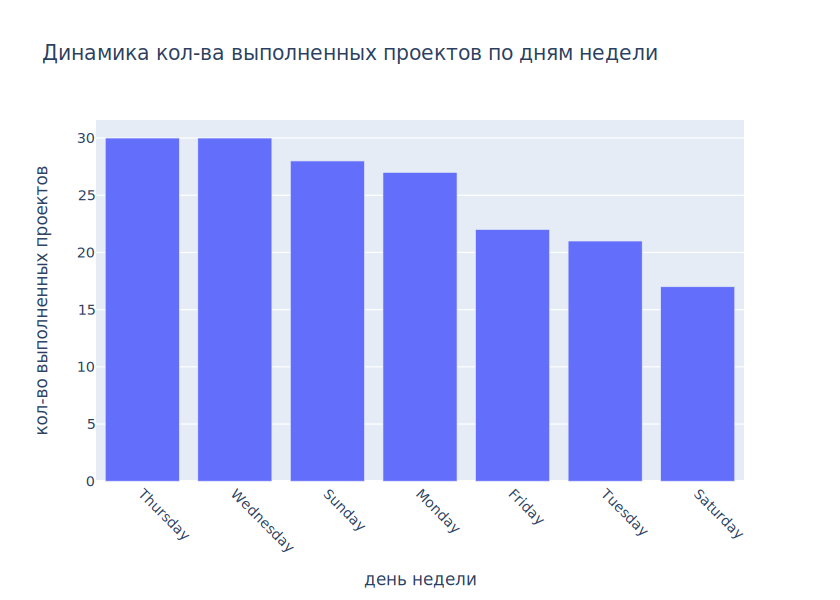

In [45]:
fig_ = px.bar(dynamics, x=dynamics.index, y=dynamics, title='Динамика кол-ва выполненных проектов по дням недели', labels=dict(week_day_ended = 'день недели', y='кол-во выполненных проектов'))
fig_.update_xaxes(tickangle=45) # повернём подписи по оси X на 50 градусов
fig_.show("svg")

In [46]:
print(f'Динамика выполнения проектов говорит о том, что пик завершенных проектов приходится на {dynamics.index[0]} и {dynamics.index[1]} - {dynamics.values[0]} и {dynamics.values[1]} проектов соответсвенно, к {dynamics.index[-0]} мы видим минимум выполненных проектов в статусе "завершено" - {dynamics.values[-1]} проектов, почти в {round(dynamics.values[0]/dynamics.values[-1],2)} раза меньше, чем пиковое значение. Следовательно можно выделить самые продуктивные дни - {dynamics.index[0]}, {dynamics.index[1]}. {dynamics.index[2]} и {dynamics.index[3]} тоже близки к пику - {dynamics.values[2]} и {dynamics.values[3]} проектов.')

Динамика выполнения проектов говорит о том, что пик завершенных проектов приходится на Thursday и Wednesday - 30 и 30 проектов соответсвенно, к Thursday мы видим минимум выполненных проектов в статусе "завершено" - 17 проектов, почти в 1.76 раза меньше, чем пиковое значение. Следовательно можно выделить самые продуктивные дни - Thursday, Wednesday. Sunday и Monday тоже близки к пику - 28 и 27 проектов.


In [47]:
dyn_per_days = data.groupby('end_date')['projects'].count().sort_values(ascending = False)
dyn_per_days

end_date
2023-07-05    20
2023-06-22    15
2023-07-02    14
2023-06-26    14
2023-06-27    13
2023-06-30    12
2023-06-24    11
2023-07-06     9
2023-07-03     9
2023-06-25     8
2023-07-04     7
2023-06-28     7
2023-06-29     6
2023-07-07     6
2023-06-18     6
2023-06-17     5
2023-06-19     4
2023-06-21     3
2023-06-23     2
2023-06-16     2
2023-07-01     1
2023-06-20     1
Name: projects, dtype: int64

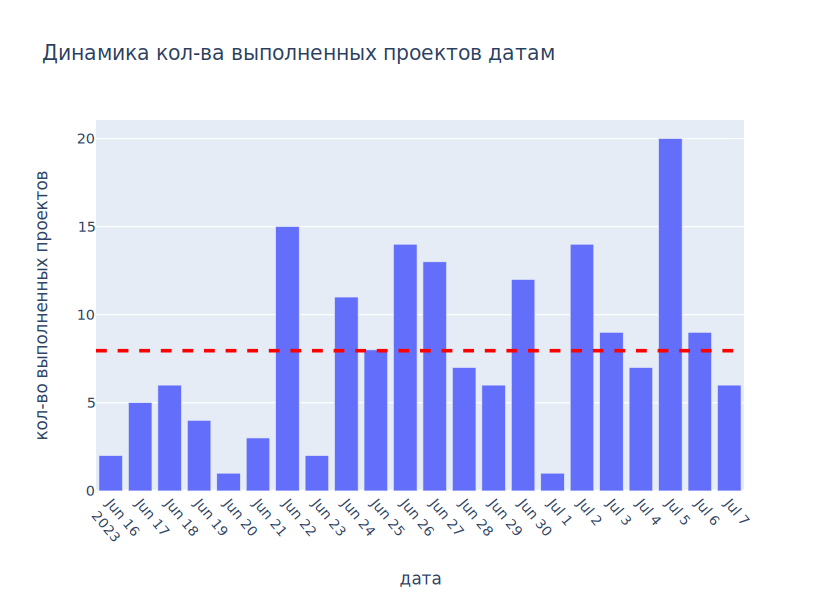

In [48]:
fig = px.bar(dyn_per_days, x=dyn_per_days.index, y=dyn_per_days, title='Динамика кол-ва выполненных проектов датам', labels=dict(end_date = 'дата', y='кол-во выполненных проектов'))
fig.update_xaxes(tickangle=50) # повенём подписи по оси X на 50 градусов
fig.update_xaxes(tickangle=50, tickmode='linear', dtick='D1')
fig.add_hline(y=dyn_per_days.values.mean(), line_width=3, line_dash="dash", line_color="red")
fig.show("svg")

Среднее кол-во проектов за рассматриваемый период составляет около 8-ми проектов. То есть , переходя за отметку 8, сотрудник делает сверхнормы. Таких дней на графике мы видим - 9 из 21.
  

In [49]:
print(f'Пиковое значение по количеству выполненных проектов приходится на {dyn_per_days.index.strftime("%Y-%m-%d")[0]}.Меньше всего проектов было сделано {dyn_per_days.index.strftime("%Y-%m-%d")[-1]}. Размах составляет {round(dyn_per_days.values[0]/dyn_per_days.values[-1],2)} проектов. В среднем в день было выполнено {round(dyn_per_days.values.mean(),2)} проектов. ')

Пиковое значение по количеству выполненных проектов приходится на 2023-07-05.Меньше всего проектов было сделано 2023-06-20. Размах составляет 20.0 проектов. В среднем в день было выполнено 7.95 проектов. 


In [50]:
data['month'] = data['end_date'].dt.month

In [51]:
data.head()

,created,start_date,end_date,projects,income,week_day_started,week_day_created,week_day_ended,month
0,2023-07-07,2023-07-05,2023-07-07,логотип,13830,Wednesday,Friday,Friday,7
1,2023-07-07,2023-07-06,2023-07-07,чат-бот,7820,Thursday,Friday,Friday,7
2,2023-07-07,2023-07-06,2023-07-07,логотип,13830,Thursday,Friday,Friday,7
3,2023-07-07,2023-07-06,2023-07-07,визитка,2000,Thursday,Friday,Friday,7
4,2023-07-07,2023-07-07,2023-07-07,facebook,5320,Friday,Friday,Friday,7


In [52]:
months = data.groupby('month')['projects'].count().sort_values(ascending = False )
months
print(f'за {months.index[0]}-й месяц было выполнено - {months.values[0]} проектов, а за  {months.index[1]}-й было выполнено {months.values[1]} проектов')

за 6-й месяц было выполнено - 109 проектов, а за  7-й было выполнено 66 проектов


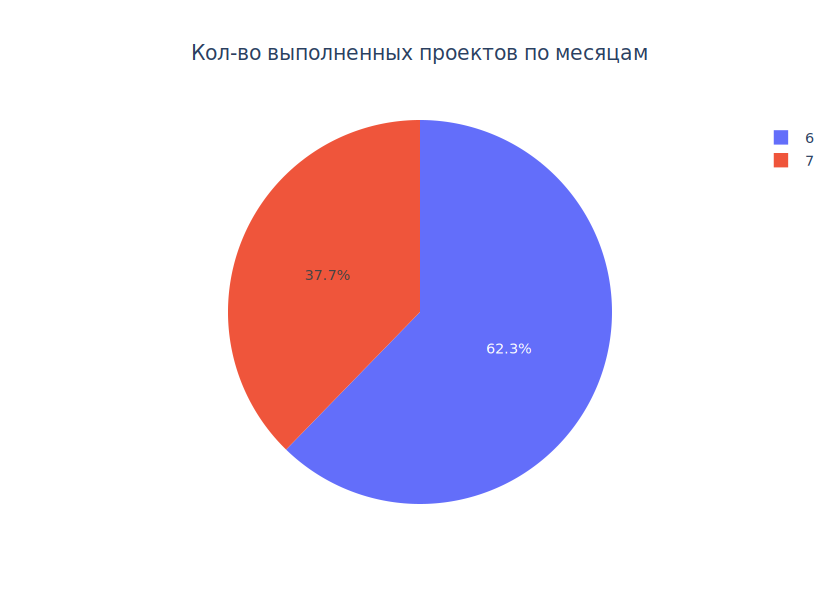

In [53]:
fig = go.Figure(data=[go.Pie(labels=months.index, values=months)])
fig.update_layout(title_text='Кол-во выполненных проектов по месяцам', title_x= 0.5)
fig.show("svg") 

**Дашборд по заработанной сумме в разрезе дней**

In [54]:
profit = data.groupby('projects')['income'].agg(['count','sum'])
profit['%_of_salary'] = (profit['sum']/salary)*100
profit = profit.sort_values('sum', ascending = False)
profit

,count,sum,%_of_salary
projects,,,
логотип,44,608520,50.593214
чат-бот,30,234600,19.504976
facebook,41,218120,18.134805
создание_сайта,51,81600,6.784339
inst,4,31960,2.657200
VK,3,23970,1.992900
баннер,1,2000,0.166283
визитка,1,2000,0.166283


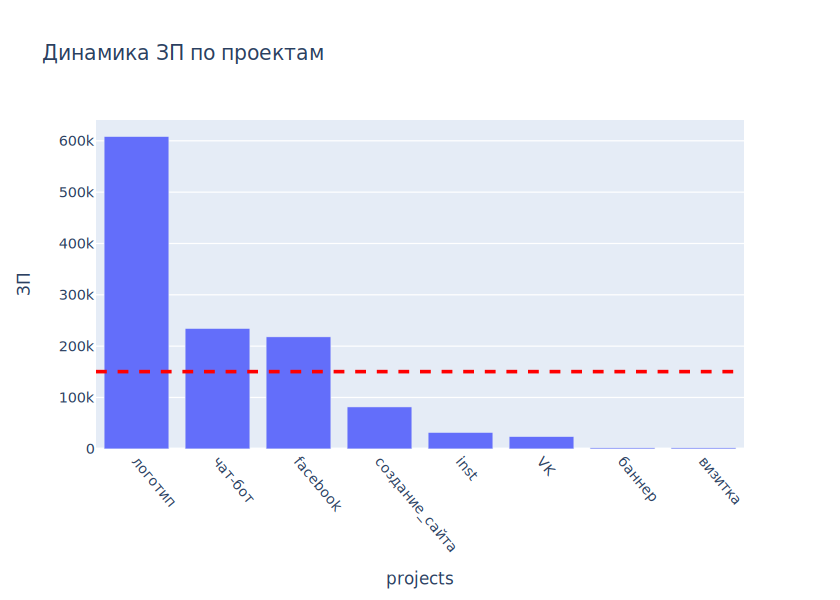

In [55]:
fig3 = px.bar(profit, x=profit.index, y=profit['sum'], title='Динамика ЗП по проектам', labels=dict(home_task = 'название проекта', sum='ЗП'))
fig3.update_xaxes(tickangle=50) # повернём подписи по оси X на 50 градусов
fig3.add_hline(y=profit['sum'].mean(), line_width=3, line_dash="dash", line_color="red")
fig3.show("svg")

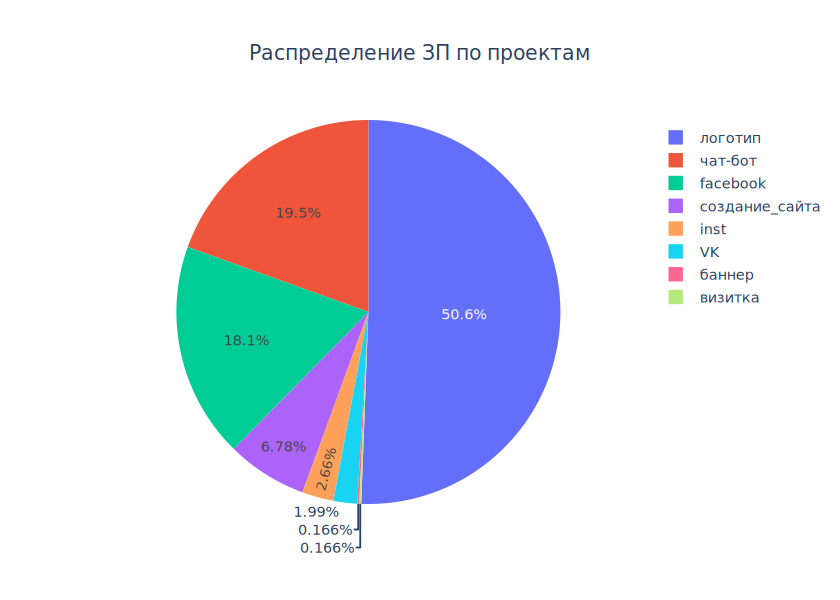

In [56]:
fig = go.Figure(data=[go.Pie(labels=profit.index, values=profit['%_of_salary'])])
fig.update_layout(title_text='Распределение ЗП по проектам', title_x= 0.5)
fig.show("svg") 

In [57]:
print(f'Наибольший доход принес заказ  {profit.index[0]} - {profit.iat[0,1]} р., что составило почти  {round(profit.iat[0,2],2)}% от общей выручки. На втором месте по доходности оказался проект {profit.index[1]} - {profit.iat[1,1]} р., что составило {round(profit.iat[1,2],2)}% от всей зп. Наименее доходными оказались проекты : {profit.index[-1]} и {profit.index[-2]}, каждый из которых принес по {profit.iat[-1,1]} и {profit.iat[-2,1]} р. соответственно')

Наибольший доход принес заказ  логотип - 608520 р., что составило почти  50.59% от общей выручки. На втором месте по доходности оказался проект чат-бот - 234600 р., что составило 19.5% от всей зп. Наименее доходными оказались проекты : визитка и баннер, каждый из которых принес по 2000 и 2000 р. соответственно


In [58]:
income_per_d = data.groupby('end_date')['income'].sum().sort_values(ascending = False)
income_per_d

end_date
2023-06-22    135860
2023-07-05    134700
2023-07-02    116880
2023-06-24    108360
2023-06-30     83420
2023-07-06     71520
2023-06-25     58570
2023-06-26     57220
2023-07-04     52160
2023-07-07     50790
2023-06-29     48100
2023-07-03     46510
2023-06-27     45470
2023-06-18     45220
2023-06-28     41880
2023-06-17     30170
2023-06-21     23250
2023-06-23     15430
2023-06-16     15430
2023-07-01     13830
2023-06-19      6400
2023-06-20      1600
Name: income, dtype: int64

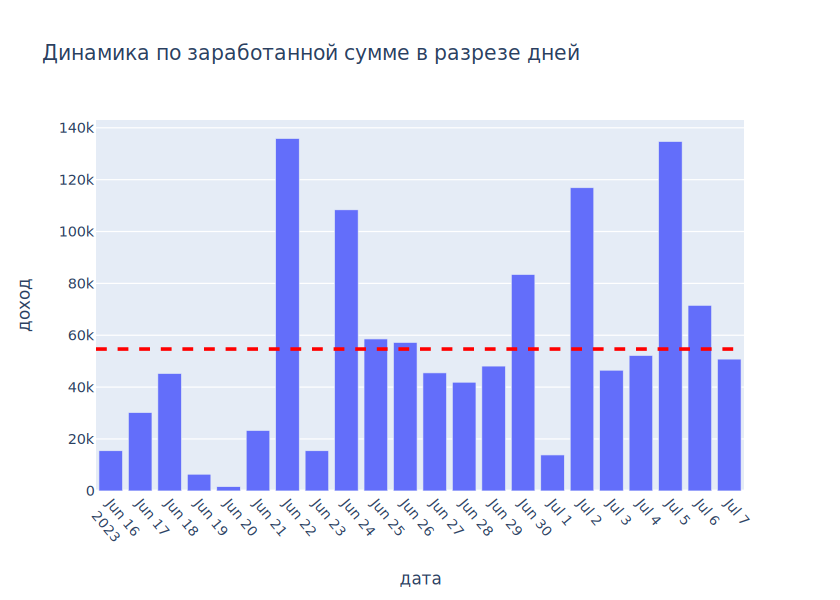

In [59]:
fig2 = px.bar(income_per_d, x=income_per_d.index, y=income_per_d, title='Динамика по заработанной сумме в разрезе дней', labels=dict(end_date = 'дата', y='доход'))
fig2.update_xaxes(tickangle=45) 
fig2.add_hline(y=income_per_d.values.mean(), line_width=3, line_dash="dash", line_color="red")
fig2.update_xaxes(tickangle=50, tickmode='linear', dtick='D1')
fig2.show("svg")

Говоря о прогнозах на будущее, на основе текущих данных, можно сказать, что постепенно уровень ЗП будет выравниваться до среднего уровня, будет меньше отклонений\аномальных значений, выше или ниже нормы. Мы по-прежнему будем наблюдать пиковые значения, так как в определенные дни скапливаются все проекты, которые нужно закрыть, и именно за этот день считается прибыль.

In [60]:
print(f'В разрезе дней {income_per_d.index.strftime("%m-%d")[0]} и {income_per_d.index.strftime("%m-%d")[1]} - самые прибыльные дни {income_per_d.values[0]} р. и {income_per_d.values[1]} р. соответственно. Меньше всего дохода пришло {income_per_d.index.strftime("%m-%d")[-1]} и {income_per_d.index.strftime("%m-%d")[-2]}, {income_per_d.values[-1]} и {income_per_d.values[-2]} рублей соответственно.')

В разрезе дней 06-22 и 07-05 - самые прибыльные дни 135860 р. и 134700 р. соответственно. Меньше всего дохода пришло 06-20 и 06-19, 1600 и 6400 рублей соответственно.


In [61]:
print(f'Средний доход в день составляет примерно {round(income_per_d.values.mean(),2)} рублей, следовательно выше этой суммы сотрудник делает работу сверхнормы')

Средний доход в день составляет примерно 54671.36 рублей, следовательно выше этой суммы сотрудник делает работу сверхнормы


In [62]:
income_per_wd = data.groupby('week_day_ended')['income'].sum().sort_values(ascending = False )
income_per_wd

week_day_ended
Thursday     255480
Sunday       220670
Wednesday    199830
Friday       165070
Saturday     152360
Monday       110130
Tuesday       99230
Name: income, dtype: int64

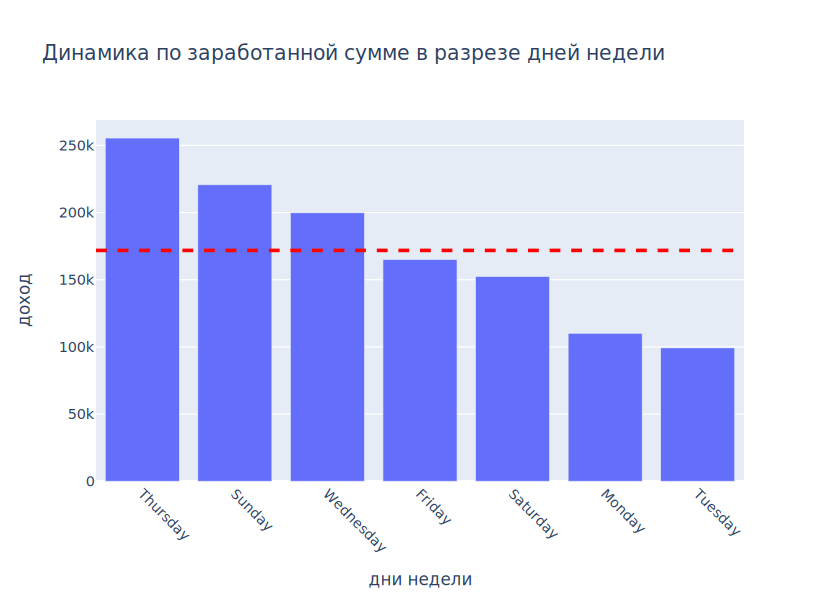

In [63]:
fig4 = px.bar(income_per_wd, x=income_per_wd.index, y=income_per_wd, title='Динамика по заработанной сумме в разрезе дней недели', labels=dict(week_day_ended = 'дни недели', y='доход'))
fig4.update_xaxes(tickangle=45) 
fig4.add_hline(y=income_per_wd.values.mean(), line_width=3, line_dash="dash", line_color="red")
fig4.show("svg")

In [64]:
print(f'{income_per_wd.index[0]} самый доходный день - {income_per_wd.values[0]} руб. было заработано в эти дни, а {income_per_wd.index[-1]} и {income_per_wd.index[-2]} наименее прибыльны - {income_per_wd.values[-1]} и {income_per_wd.values[-2]} рублей соответсвенно было получены в каждый из дней. В среднем в эти дни в {round(income_per_wd.values[0]/((income_per_wd.values[-2]+income_per_wd.values[-1])/2),2)} раза меньше было заработка, чем в {income_per_wd.index[0]}')

Thursday самый доходный день - 255480 руб. было заработано в эти дни, а Tuesday и Monday наименее прибыльны - 99230 и 110130 рублей соответсвенно было получены в каждый из дней. В среднем в эти дни в 2.44 раза меньше было заработка, чем в Thursday


## Дашборды в Tableau

Динамика прибыли и кол-ва проектов в разрезе дней

https://public.tableau.com/app/profile/.25533259/viz/1_16907949848390/Dashboard1?publish=yes

Динамика по доходу и кол-ву выполненных проектов в разрезе дат и вида проектов

https://public.tableau.com/app/profile/.25533259/viz/2_16907950449170/Dashboard2?publish=yes

## Статистика

**Проверка гипотез с помощью т-теста**

За представленный период воскресенья и среды принесли похожий доход: 22 и 19,9 тысяч соответсвенно. Рассмотрим существующие различия с точки зрения статистики.

Для проверки гипотез используем т-критерий, так как именно он помогает сравнить две выборки между собой на предмет статистически значимых различий. Из существующих уровней значимости выберем 0,05, то есть существует 5% того, что результат обусловлен случайностью.

Для использования т-теста необходимы 2 условия:

 - гомогенность дисперсий
 
 - Нормальность распределения в группах 

Проверим для начала распределение в группах на **нормальность:**

In [65]:
wed = data[data['week_day_ended']=='Wednesday']['income']
sun = data[data['week_day_ended']=='Sunday']['income']

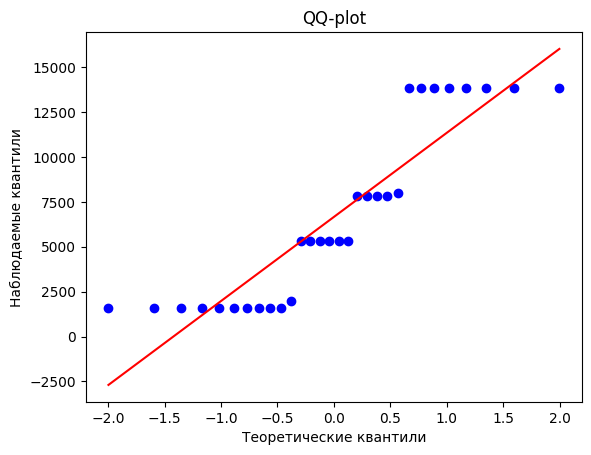

In [66]:
wednesday = wed.values

# Построение QQ-plot
st.probplot(wednesday, dist="norm", plot=plt)

plt.xlabel('Теоретические квантили')
plt.ylabel('Наблюдаемые квантили')
plt.title('QQ-plot')


plt.show()

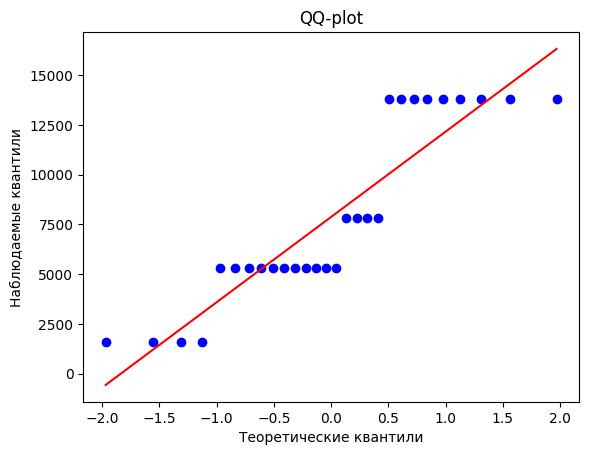

In [67]:
sunday = sun.values

# Построение QQ-plot
st.probplot(sunday, dist="norm", plot=plt)

plt.xlabel('Теоретические квантили')
plt.ylabel('Наблюдаемые квантили')
plt.title('QQ-plot')


plt.show()

Нам известно, что графики построены по ценам на проекты, поэтому данные распределены ценовыми сегментами в районе 250 , 750 и 1300. Учитывая специфику данных, отклонение от диагонали не так критичны. Следовательно, мы можем использовать данные для проведения т-теста.

Проверим данные на **гомогенность дисперсий** с помощью теста Левена:

In [68]:
st.levene(wednesday, sunday, center='median')

LeveneResult(statistic=0.22355924238388647, pvalue=0.6381789467552113)

P - value имеет показатель > 0,05. Следовательно, мы не отвергаем гипотезу о равенстве дисперсий. Таким образом, параметр о гомогенности дисперсий соблден. -> Можем проводить т-тест.

**Нулевая гипотеза:** Статистически значимые различия между доходом от сред и вскр-й отсутствуют.
    
**Альтернативная гипотеза:** Статистически значимые различия между доходом от сред и от вскр-й существуют.

In [69]:
# Первая гипотеза

alpha = .05

results = st.ttest_ind(
    wed, 
    sun)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.33098864763669655
Не получилось отвергнуть нулевую гипотезу


Т-криетрий Стьюдента показал, что статистически значимых различий между доходом от сред и воскресений нет.

Рассмотрим еще две выборки. Доход за 22 июня и за 5 июля - за самые прибыльные дни. Есть ли между ними статистически значимые различия ?

Для проверки гипотез также используем т-критерий с аналогичным уровнем значимости и проверим аналогичным образом условия для проведения т-теста.

In [70]:
june = data[data['end_date']=='2023-06-22']['income']
july = data[data['end_date']=='2023-07-05']['income']

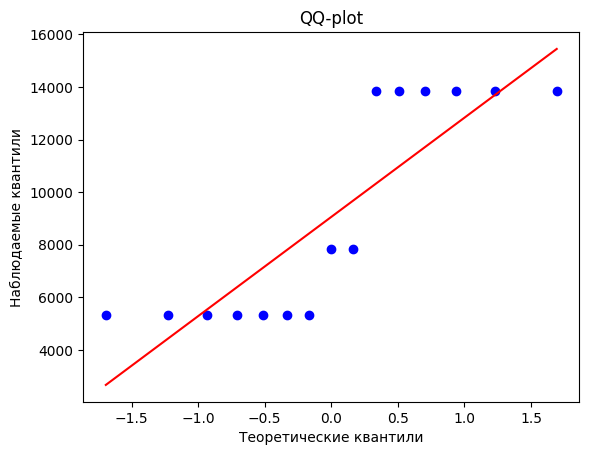

In [71]:
jun = june.values

# Построение QQ-plot
st.probplot(jun, dist="norm", plot=plt)

plt.xlabel('Теоретические квантили')
plt.ylabel('Наблюдаемые квантили')
plt.title('QQ-plot')


plt.show()

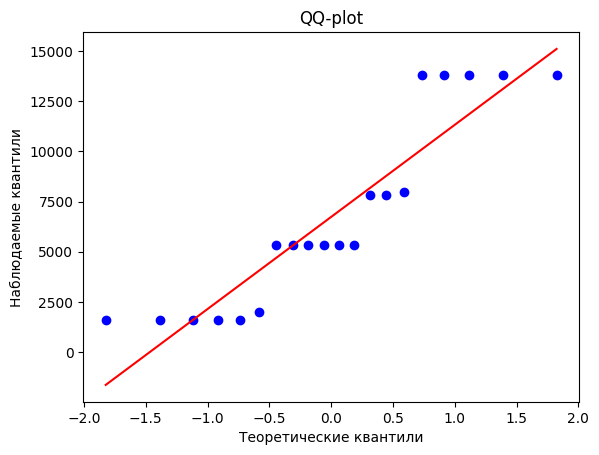

In [72]:
jul = july.values

# Построение QQ-plot
st.probplot(jul, dist="norm", plot=plt)

plt.xlabel('Теоретические квантили')
plt.ylabel('Наблюдаемые квантили')
plt.title('QQ-plot')


plt.show()

In [73]:
st.levene(jun, jul, center='median')

LeveneResult(statistic=0.0013780711165228094, pvalue=0.9706110878868098)

Мы видим аналогичную ситуацию с нормальным распределением и тестом Левена.-> Также можем провести т-тест.

**Нулевая гипотеза:** Статистически значимые различия между доходом от 22 июня и от 5 июля отсутствуют.
    
**Альтернативная гипотеза:** Статистически значимые различия между доходом от 22 июня и от 5 июля существуют.

In [74]:
# Втрая гипотеза

results = st.ttest_ind(
    june, 
    july)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.13778244810518914
Не получилось отвергнуть нулевую гипотезу


Т-критерий Стьюдента показал, что статистически значимых различий между доходом от самых прибыльных дней - нет, то есть между 5 июля и 22 июня.

**Проведение двустороннего дисперсионного анализа0**

Проведем двусторонний ANOVA, возьмем доход за зависимую переменную и посмотрим, как на нее влияет месяц и день недели.

In [75]:
# Проведение двустороннего дисперсионного анализа
model = ols('income ~ C(week_day_ended) + C(month)', data=data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print(anova_table)

                         sum_sq     df         F    PR(>F)
C(week_day_ended)  5.253439e+08    6.0  4.600790  0.000238
C(month)           5.007775e+07    1.0  2.631387  0.106657
Residual           3.178166e+09  167.0       NaN       NaN


Интерпретация результатов :

 - Последний столбец показывает p- уровень значимости. День недели p-value < 0,05. Следовательно, фактор дня недели оказывает статистически значимый результат. 
 - А вот p- уровень значимости для месяца >0,05. Получается, что фактор месяца в данном случае никак не влияет на доход.

In [76]:
display(HTML("<h1>Выводы:</h1>"))
print()
print(f' - Данные для анализа находятся в промежутке с {data.created.min().strftime("%Y-%m-%d")} по {data.end_date.max().strftime("%Y-%m-%d")}, то есть \033[1m{days}\033[0m день.')
print()
print(f' - {income_per_wd.index[0]} самый \033[1mдоходный\033[0m день - {income_per_wd.values[0]} руб. было заработано в эти дни, а {income_per_wd.index[-1]} и {income_per_wd.index[-2]} \033[1mнаименее прибыльны\033[0m - {income_per_wd.values[-1]} и {income_per_wd.values[-2]} рублей соответсвенно было получены в каждый из дней.')
print()
print(f' - В разрезе дней {income_per_d.index.strftime("%m-%d")[0]} и {income_per_d.index.strftime("%m-%d")[1]} - самые \033[1mприбыльные дни\033[0m {income_per_d.values[0]} р. и {income_per_d.values[1]} р. соответсвенно. \033[1mМеньше всего дохода\033[0m пришло {income_per_d.index.strftime("%m-%d")[-1]} и {income_per_d.index.strftime("%m-%d")[-2]}, {income_per_d.values[-1]} и {income_per_d.values[-2]} рублей соответственно.')
print()
print(f' - \033[1mНаибольший доход\033[0m принес \033[1mпроект\033[0m {profit.index[0]} - {profit.iat[0,1]} р., что составило почти  {round(profit.iat[0,2],2)}% от общей выручки. На втором месте по доходности оказался проект {profit.index[1]} - {profit.iat[1,1]} р., что составило {round(profit.iat[1,2],2)}% от всей зп. \033[1mНаименее доходными\033[0m оказались проекты : {profit.index[-1]} и {profit.index[-2]}.')
print()
print(f' - за {months.index[0]}-й месяц было выполнено - {months.values[0]} проектов, а за  {months.index[1]}-й было выполнено {months.values[1]} проектов')
print()  
print(f' - \033[1mПиковое значение\033[0m по количеству выполненных \033[1mпроектов\033[0m приходится на {dyn_per_days.index.strftime("%Y-%m-%d")[0]}.\033[1mМеньше всего проектов\033[0m было сделано {dyn_per_days.index.strftime("%Y-%m-%d")[-1]}. Размах составляет {round(dyn_per_days.values[0]/dyn_per_days.values[-1],2)} проектов. В среднем в день было выполнено {round(dyn_per_days.values.mean(),2)} проектов. ')
print()
print(f' - {count_of_pr_per_wd.index[0]} - тяжелый день, на него приходится наибольшее кол-во работы. А меньше всего проектов ревьюер проверяет в {count_of_pr_per_wd.index[-1]} и в {count_of_pr_per_wd.index[-2]}.')
print()
print(f' - Мы видим, что \033[1mпиковые дни\033[0m по кол-ву проектов приходятся на {clients.index.strftime("%Y-%m-%d")[0]}, то есть {peak_days.iat[0,4]}, и {clients.index.strftime("%Y-%m-%d")[1]} - {peak_days.iat[-1,4]}.')
print()
print(f' -  В среднем \033[1mв день\033[0m 1 проект приносит {round(sal_day/pr_day, 2)} рублей')
print()
print(f' -  В среднем \033[1mза день\033[0m выполняется {round(pr_day,2)} проектов')
print()
print(f' -  В среднем \033[1mза неделю\033[0m выполняется {round(pr_week,2)} проектов')
print()
print(f' - \033[1mЗП\033[0m за {days} день составила - {salary} руб. без учета налога. \033[1mС учетом налога\033[0m: {round(salary * 0.94,2)}. В среднем получается, что \033[1mнедельный заработок\033[0m составил {sal_week} руб, а \033[1mдневной\033[0m - {sal_day} руб.')
print()
print(f' - \033[1mБольше всего выполнено проектов\033[0m таких как {project.index[0]}, а также {project.index[1]} и {project.index[2]}. Неприоритетными в этом отчетном периоде оказались: {project.index[-1]}, {project.index[-2]} и {project.index[-3]}.')


 - Данные для анализа находятся в промежутке с 2023-06-16 по 2023-07-07, то есть 21 день.

 - Thursday самый доходный день - 255480 руб. было заработано в эти дни, а Tuesday и Monday наименее прибыльны - 99230 и 110130 рублей соответсвенно было получены в каждый из дней.

 - В разрезе дней 06-22 и 07-05 - самые прибыльные дни 135860 р. и 134700 р. соответсвенно. Меньше всего дохода пришло 06-20 и 06-19, 1600 и 6400 рублей соответственно.

 - Наибольший доход принес проект логотип - 608520 р., что составило почти  50.59% от общей выручки. На втором месте по доходности оказался проект чат-бот - 234600 р., что составило 19.5% от всей зп. Наименее доходными оказались проекты : визитка и баннер.

 - за 6-й месяц было выполнено - 109 проектов, а за  7-й было выполнено 66 проектов

 - Пиковое значение по количеству выполненных проектов приходится на 2023-07-05.Меньше всего проектов было сделано 2023-06-20. Размах составляет 20.0 проектов. В среднем в день было выполнено 7.95 проектов. 

 - M